We import all the standard stuff that we usually need for machine learning in python

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

# get rid of warnings
import warnings
warnings.filterwarnings("ignore")

Let's generate some data to play with. We will generate a dataset with `225` total samples and `500` features, out of which only `50` (10%) are informative/relevant. We should be able to find the relevant features using regularization.

In [71]:
n_samples_train, n_samples_test, n_features = 75, 150, 500
X, y, coef = make_regression(
    n_samples=n_samples_train + n_samples_test,
    n_features=n_features,
    n_informative=50,
    shuffle=False,
    noise=1.0,
    coef=True,
)

Here, we use `sklearn.train_test_split` to split the data in two parts: a _training_ partition and a _test_ partition.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=n_samples_train, test_size=n_samples_test, shuffle=False
)

Now, we take a look at elastic net regularization. In Python, the ElasticNet has the following parameters:

- `l1_ratio`: corresponds to the $\alpha$ parameter in our lecture slides - the elastic net mixing parameter which controls the balance between the `L1` and `L2` penalty terms.

- `alpha`: corresponds to the $\lambda$ parameter in our lecture slides - the constant that multiplies the penalty terms (controls the strength of the regularization).

We would like to find the optimal $\alpha$ parameter.

In [73]:
alphas = np.logspace(-5, 1, 60)
enet = ElasticNet(l1_ratio=0.7, max_iter=10000)
train_errors = []
test_errors = []

for alpha in alphas:
    enet.set_params(alpha=alpha)
    enet.fit(X_train, y_train)
    train_errors.append(enet.score(X_train, y_train))
    test_errors.append(enet.score(X_test, y_test))

best_alpha_index = np.argmax(test_errors)
best_alpha = alphas[best_alpha_index]
print("Optimal regularization parameter: ", best_alpha)

# Estimate the coef_ on full data with optimal regularization parameter
enet.set_params(alpha=best_alpha)
coef_ = enet.fit(X, y).coef_

Optimal regularization parameter:  0.00026529484644318975


It's a little hard to read these results and understand what is going on. Let's visualize the errors with respect to each value of $\alpha$:

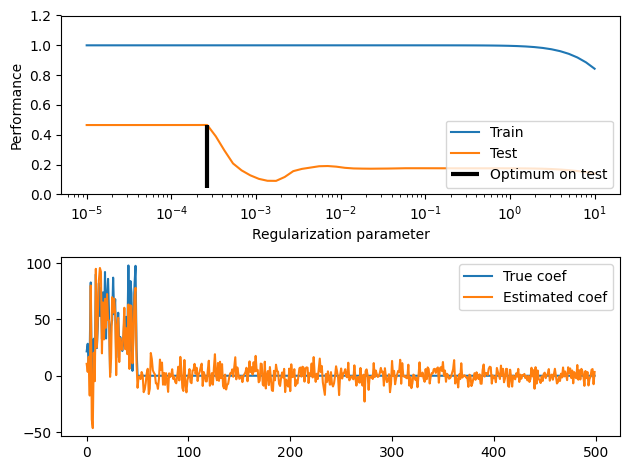

In [74]:
fig, axes = plt.subplots(nrows=2, ncols=1)
ax = axes[0] # use the axis corresponding to the first subplot
ax.semilogx(alphas, train_errors, label="Train") # plot using log scaling on the x-axis
ax.semilogx(alphas, test_errors, label="Test")   # plot using log scaling on the x-axis
ax.vlines(
    best_alpha,
    ax.get_ylim()[0],
    np.max(test_errors),
    color="k",
    linewidth=3,
    label="Optimum on test",
)
ax.legend(loc="lower right")
ax.set_ylim([0, 1.2])
ax.set_xlabel("Regularization parameter")
ax.set_ylabel("Performance")

# Show estimated coef_ vs true coef
ax = axes[1] # use the axis corresponding to the second subplot
ax.plot(coef, label="True coef")
ax.plot(coef_, label="Estimated coef")
ax.legend()

fig.tight_layout()

Finding `ElasticNet` parameters using cross-validation: `sklearn.model_selection.GridSearchCV`

In [75]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'alpha': np.logspace(-5, 1, 60),
    'l1_ratio': np.linspace(0, 1, 10)
}

enet = ElasticNet(max_iter=10000)

gs = GridSearchCV(estimator=enet, param_grid=parameters, cv=5)
gs.fit(X_train, y_train)

print('Best score: ', gs.best_score_)
print('Best parameters:', gs.best_params_)

Best score:  0.4627849068389775
Best parameters: {'alpha': 0.00016608827826277166, 'l1_ratio': 0.4444444444444444}


Text(0.5, 1.0, '$R^2_{test}$ = 0.165')

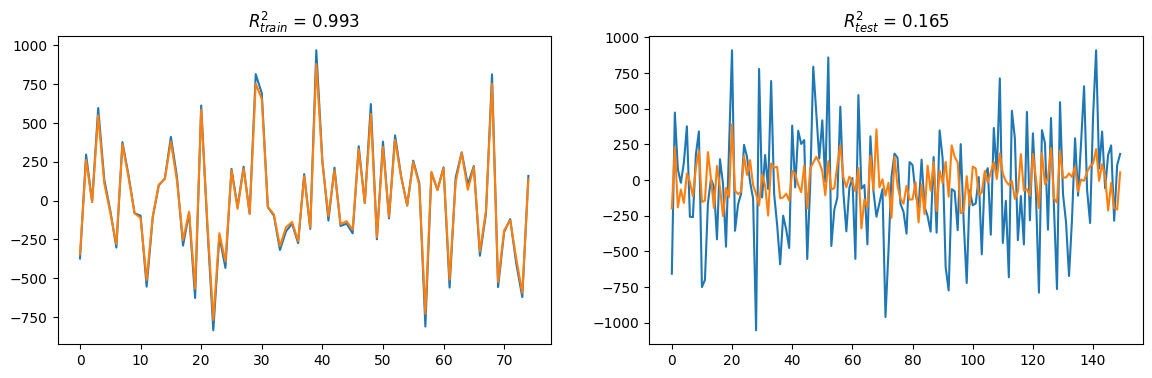

In [96]:
best = gs.best_estimator_

best.fit(X_train, y_train)
y_train_pred = best.predict(X_train)
y_test_pred = best.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

ax = axes[0]
ax.plot(range(X_train.shape[0]), y_train, label='$y$')
ax.plot(range(X_train.shape[0]), y_train_pred, label='$\hat{y}$')
ax.set_title(f'$R^2_{{train}}$ = {r2_train:.3f}')

ax = axes[1]
ax.plot(range(X_test.shape[0]), y_test, label='$y$')
ax.plot(range(X_test.shape[0]), y_test_pred, label='$\hat{y}$')
ax.set_title(f'$R^2_{{test}}$ = {r2_test:.3f}')